In [1]:
import pandas as pd

# Load both datasets
employee_df = pd.read_csv('Employee.csv')
performance_df = pd.read_csv('performance rating.csv')

# Display the first few rows of each dataset to verify loading
print("Employee Data Sample:")
print(employee_df.head())
print("\nPerformance Rating Data Sample:")
print(performance_df.head())

# Merge the datasets on EmployeeID
# Using left join to keep all employees even if they lack performance data
merged_df = pd.merge(
    employee_df,
    performance_df,
    on='EmployeeID',
    how='left'
)

# Display information about the merged dataframe
print("\nMerged Dataframe Info:")
print(merged_df.info())

# Show sample of merged data
print("\nMerged Data Sample:")
print(merged_df.head())

# Optional: Save the merged data to a new CSV file
merged_df.to_csv('employee_performance_merged.csv', index=False)
print("\nMerged data saved to 'employee_performance_merged.csv'")

Employee Data Sample:
  EmployeeID   FirstName LastName      Gender  Age BusinessTravel  \
0  3012-1A41    Leonelle    Simco      Female   30    Some Travel   
1  CBCB-9C9D     Leonerd    Aland        Male   38    Some Travel   
2  95D7-1CE9       Ahmed    Sykes        Male   43    Some Travel   
3  47A0-559B  Ermentrude   Berrie  Non-Binary   39    Some Travel   
4  42CC-040A       Stace   Savege      Female   29    Some Travel   

        Department  DistanceFromHome (KM)  
0            Sales                     27  
1            Sales                     23  
2  Human Resources                     29  
3       Technology                     12  
4  Human Resources                     29  

Performance Rating Data Sample:
  PerformanceID EmployeeID ReviewDate  EnvironmentSatisfaction  \
0          PR01  79F7-78EC   1/2/2013                        5   
1          PR02  B61E-0F26   1/3/2013                        5   
2          PR03  F5E3-48BB   1/3/2013                        3   
3 

In [2]:
# Fill missing performance metrics with median values
performance_cols = ['EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']
merged_df[performance_cols] = merged_df[performance_cols].fillna(merged_df[performance_cols].median())

In [13]:
import numpy as np

# Load datasets with proper data types
employee_df = pd.read_csv('Employee.csv')
performance_df = pd.read_csv('performance rating.csv', parse_dates=['ReviewDate'])

# Data Cleaning - Employee Data
def clean_employee_data(df):
    # Standardize text columns
    text_cols = ['FirstName', 'LastName', 'Gender', 'BusinessTravel', 'Department']
    df[text_cols] = df[text_cols].apply(lambda x: x.str.strip().str.title())
    
    # Handle numeric columns
    df['Age'] = df['Age'].clip(lower=18, upper=70)  # Reasonable age range
    df['DistanceFromHome (KM)'] = df['DistanceFromHome (KM)'].clip(lower=0)
    
    # Create useful features
    df['AgeGroup'] = pd.cut(df['Age'], 
                           bins=[18, 25, 35, 45, 55, 70],
                           labels=['18-25', '26-35', '36-45', '46-55', '56+'])
    return df

# Data Cleaning - Performance Data
def clean_performance_data(df):
    # Convert ratings to categorical with proper ordering
    rating_cols = ['EnvironmentSatisfaction', 'JobSatisfaction', 
                  'RelationshipSatisfaction', 'WorkLifeBalance']
    
    for col in rating_cols:
        df[col] = pd.Categorical(df[col], 
                                categories=[1, 2, 3, 4, 5],
                                ordered=True)
    
    # Handle training opportunities
    df['TrainingUtilization'] = (df['TrainingOpportunitiesTaken'] / 
                               df['TrainingOpportunitiesWithinYear']).replace(np.inf, 0)
    
    # Keep only the most recent performance review per employee
    df = df.sort_values('ReviewDate').groupby('EmployeeID').last().reset_index()
    
    return df

# Clean both datasets
employee_df = clean_employee_data(employee_df)
performance_df = clean_performance_data(performance_df)

# Intelligent Merging with Validation
def merge_with_validation(emp_df, perf_df):
    # Validate merge keys
    emp_ids = set(emp_df['EmployeeID'])
    perf_ids = set(perf_df['EmployeeID'])
    
    print(f"Employees without performance data: {len(emp_ids - perf_ids)}")
    print(f"Performance records without employee data: {len(perf_ids - emp_ids)}")
    
    # Merge with inner join to ensure complete cases
    merged_df = pd.merge(
        emp_df,
        perf_df,
        on='EmployeeID',
        how='inner',  # Only employees with performance data
        validate='one_to_one'  # Ensure no duplicates
    )
    
    return merged_df

# Perform the merge
analysis_df = merge_with_validation(employee_df, performance_df)

# Final Data Quality Checks
def final_quality_checks(df):
    # Check for missing values
    missing = df.isnull().sum()
    print("\nMissing Values Check:")
    print(missing[missing > 0])
    
    # Check for duplicates
    print(f"\nDuplicate Rows: {df.duplicated().sum()}")
    
    # Check data distributions
    print("\nNumeric Data Distributions:")
    print(df.describe())
    
    return df

# Apply quality checks
analysis_df = final_quality_checks(analysis_df)



Employees without performance data: 190
Performance records without employee data: 0

Missing Values Check:
AgeGroup    4
dtype: int64

Duplicate Rows: 0

Numeric Data Distributions:
               Age  DistanceFromHome (KM)           ReviewDate  \
count  1280.000000            1280.000000                 1280   
mean     29.654688              22.390625  2022-02-04 04:07:30   
min      18.000000               1.000000  2013-04-23 00:00:00   
25%      24.000000              12.000000  2022-02-19 00:00:00   
50%      27.000000              22.000000  2022-05-18 12:00:00   
75%      35.000000              33.000000  2022-09-02 00:00:00   
max      51.000000              45.000000  2022-12-31 00:00:00   
std       7.831462              12.784210                  NaN   

       TrainingOpportunitiesWithinYear  TrainingOpportunitiesTaken  \
count                      1280.000000                 1280.000000   
mean                          2.034375                    0.975000   
min         

In [7]:
analysis_df

,EmployeeID,FirstName,LastName,Gender,Age,BusinessTravel,Department,DistanceFromHome (KM),AgeGroup,PerformanceID,ReviewDate,EnvironmentSatisfaction,JobSatisfaction,RelationshipSatisfaction,TrainingOpportunitiesWithinYear,TrainingOpportunitiesTaken,WorkLifeBalance,SelfRating,ManagerRating,TrainingUtilization
0,3012-1A41,Leonelle,Simco,Female,30,Some Travel,Sales,27,26-35,PR6529,2022-10-29,4,2,4,1,0,2,5,4,0.0
1,CBCB-9C9D,Leonerd,Aland,Male,38,Some Travel,Sales,23,36-45,PR6295,2022-07-29,3,4,4,3,0,2,5,4,0.0
2,95D7-1CE9,Ahmed,Sykes,Male,43,Some Travel,Human Resources,29,36-45,PR5918,2022-04-07,4,5,3,3,0,4,4,3,0.0
3,47A0-559B,Ermentrude,Berrie,Non-Binary,39,Some Travel,Technology,12,36-45,PR5879,2022-03-26,1,4,3,2,2,3,3,3,1.0
4,42CC-040A,Stace,Savege,Female,29,Some Travel,Human Resources,29,26-35,PR4958,2021-05-12,3,4,3,1,2,5,3,2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,3E4A-F28F,Rubi,Hawkwood,Female,20,Some Travel,Technology,45,18-25,PR6566,2022-11-10,5,2,4,1,1,4,4,4,1.0
1276,1CB3-F7D7,Janot,Cicchillo,Female,21,No Travel,Sales,6,18-25,PR6448,2022-09-27,4,2,2,1,1,5,4,3,1.0
1277,B005-602F,Layney,Ratie,Female,19,Some Travel,Technology,11,18-25,PR5821,2022-03-09,5,3,5,1,1,5,4,3,1.0
1278,45F9-3A37,Talbot,Sturgess,Male,21,Some Travel,Technology,34,18-25,PR6077,2022-05-22,1,4,1,3,0,4,4,3,0.0


In [9]:
def create_analysis_features(df):
    """
    Creates all derived features for the HR analysis dataset
    with error handling for missing columns
    """
    try:
        # 1. Composite Scores
        df['OverallSatisfaction'] = (
            df['EnvironmentSatisfaction'].cat.codes + 
            df['JobSatisfaction'].cat.codes + 
            df['WorkLifeBalance'].cat.codes
        ) / 3
        
        # 2. Performance Metrics
        df['RatingDiscrepancy'] = df['SelfRating'] - df['ManagerRating']
        df['PerformanceGap'] = np.abs(df['RatingDiscrepancy'])
        
        # 3. Age Features
        df['AgeBand'] = pd.cut(
            df['Age'],
            bins=[18, 30, 40, 50, 70],
            labels=['18-29', '30-39', '40-49', '50+'],
            right=False
        )
        
        # 4. Distance Features
        df['DistanceCategory'] = pd.cut(
            df['DistanceFromHome (KM)'],
            bins=[0, 5, 10, 20, 50, float('inf')],
            labels=['0-5km', '5-10km', '10-20km', '20-50km', '50+km']
        )
        
        df['CommuteSeverity'] = pd.cut(
            df['DistanceFromHome (KM)'],
            bins=[0, 10, 20, float('inf')],
            labels=['Low', 'Medium', 'High']
        )
        
        # 5. Employee Information
        df['FullName'] = df['FirstName'] + ' ' + df['LastName']
        
        # 6. Department Encoding (for ML)
        dept_map = {dept: idx for idx, dept in enumerate(df['Department'].unique())}
        df['DepartmentEncoded'] = df['Department'].map(dept_map)
        
        # 7. Tenure Estimation (using ReviewDate as proxy)
        current_year = pd.Timestamp.now().year
        df['TenureYears'] = current_year - df['ReviewDate'].dt.year
        df['TenureCategory'] = pd.cut(
            df['TenureYears'],
            bins=[0, 1, 3, 5, 10, float('inf')],
            labels=['<1yr', '1-3yrs', '3-5yrs', '5-10yrs', '10+yrs']
        )
        
        # 8. Travel Features (only if column exists)
        if 'TravelFrequency' in df.columns:
            df['TravelFrequencyCategory'] = pd.cut(
                df['TravelFrequency'],
                bins=[-1, 0, 3, 6, float('inf')],
                labels=['None', 'Low', 'Medium', 'High']
            )
        else:
            print("Warning: 'TravelFrequency' column not found - skipping TravelFrequencyCategory")
        
        # 9. Performance Year
        df['PerformanceYear'] = df['ReviewDate'].dt.year
        
    except KeyError as e:
        print(f"Error: Missing required column - {e}")
        print("Available columns:", df.columns.tolist())
        raise
        
    return df

# Apply feature engineering with error handling
try:
    analysis_df = create_analysis_features(analysis_df)
except Exception as e:
    print(f"Failed to create features: {e}")
    # Optionally continue with unmodified dataframe
    analysis_df = analysis_df.copy()

# Verify all features were created
expected_features = [
    'OverallSatisfaction', 'RatingDiscrepancy', 'PerformanceGap',
    'AgeBand', 'DistanceCategory', 'CommuteSeverity', 'FullName',
    'DepartmentEncoded', 'TenureYears', 'TenureCategory',
    'PerformanceYear'  # Removed TravelFrequencyCategory from required features
]

print("\nFeature Creation Verification:")
created_features = [f for f in expected_features if f in analysis_df.columns]
missing_features = [f for f in expected_features if f not in analysis_df.columns]
print(f"Created features: {created_features}")
print(f"Missing features: {missing_features if missing_features else 'None'}")

# Final Data Structure
print("\nFinal Data Structure:")
print(analysis_df.info())


Feature Creation Verification:
Created features: ['OverallSatisfaction', 'RatingDiscrepancy', 'PerformanceGap', 'AgeBand', 'DistanceCategory', 'CommuteSeverity', 'FullName', 'DepartmentEncoded', 'TenureYears', 'TenureCategory', 'PerformanceYear']
Missing features: None

Final Data Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   EmployeeID                       1280 non-null   object        
 1   FirstName                        1280 non-null   object        
 2   LastName                         1280 non-null   object        
 3   Gender                           1280 non-null   object        
 4   Age                              1280 non-null   int64         
 5   BusinessTravel                   1280 non-null   object        
 6   Department                       1280 non-

In [10]:
analysis_df

,EmployeeID,FirstName,LastName,Gender,Age,BusinessTravel,Department,DistanceFromHome (KM),AgeGroup,PerformanceID,...,RatingDiscrepancy,PerformanceGap,AgeBand,DistanceCategory,CommuteSeverity,FullName,DepartmentEncoded,TenureYears,TenureCategory,PerformanceYear
0,3012-1A41,Leonelle,Simco,Female,30,Some Travel,Sales,27,26-35,PR6529,...,1,1,30-39,20-50km,High,Leonelle Simco,0,3,1-3yrs,2022
1,CBCB-9C9D,Leonerd,Aland,Male,38,Some Travel,Sales,23,36-45,PR6295,...,1,1,30-39,20-50km,High,Leonerd Aland,0,3,1-3yrs,2022
2,95D7-1CE9,Ahmed,Sykes,Male,43,Some Travel,Human Resources,29,36-45,PR5918,...,1,1,40-49,20-50km,High,Ahmed Sykes,1,3,1-3yrs,2022
3,47A0-559B,Ermentrude,Berrie,Non-Binary,39,Some Travel,Technology,12,36-45,PR5879,...,0,0,30-39,10-20km,Medium,Ermentrude Berrie,2,3,1-3yrs,2022
4,42CC-040A,Stace,Savege,Female,29,Some Travel,Human Resources,29,26-35,PR4958,...,1,1,18-29,20-50km,High,Stace Savege,1,4,3-5yrs,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,3E4A-F28F,Rubi,Hawkwood,Female,20,Some Travel,Technology,45,18-25,PR6566,...,0,0,18-29,20-50km,High,Rubi Hawkwood,2,3,1-3yrs,2022
1276,1CB3-F7D7,Janot,Cicchillo,Female,21,No Travel,Sales,6,18-25,PR6448,...,1,1,18-29,5-10km,Low,Janot Cicchillo,0,3,1-3yrs,2022
1277,B005-602F,Layney,Ratie,Female,19,Some Travel,Technology,11,18-25,PR5821,...,1,1,18-29,10-20km,Medium,Layney Ratie,2,3,1-3yrs,2022
1278,45F9-3A37,Talbot,Sturgess,Male,21,Some Travel,Technology,34,18-25,PR6077,...,1,1,18-29,20-50km,High,Talbot Sturgess,2,3,1-3yrs,2022


In [12]:
# Save the data to Excel (most basic version)
analysis_df.to_excel('employee_analysis.xlsx', index=False)

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Exploratory Data Analysis (EDA)

In [20]:
# Step 2: Load Data
df = pd.read_excel("employee_analysis.xlsx")

In [21]:
# Step 3: Initial Data Check
print("First 5 rows:")
print(df.head())

print("\nData shape:", df.shape)
print("\nColumn names:", df.columns.tolist())

First 5 rows:
  EmployeeID   FirstName LastName      Gender  Age BusinessTravel  \
0  3012-1A41    Leonelle    Simco      Female   30    Some Travel   
1  CBCB-9C9D     Leonerd    Aland        Male   38    Some Travel   
2  95D7-1CE9       Ahmed    Sykes        Male   43    Some Travel   
3  47A0-559B  Ermentrude   Berrie  Non-Binary   39    Some Travel   
4  42CC-040A       Stace   Savege      Female   29    Some Travel   

        Department  DistanceFromHome (KM) AgeGroup PerformanceID  ...  \
0            Sales                     27    26-35        PR6529  ...   
1            Sales                     23    36-45        PR6295  ...   
2  Human Resources                     29    36-45        PR5918  ...   
3       Technology                     12    36-45        PR5879  ...   
4  Human Resources                     29    26-35        PR4958  ...   

  RatingDiscrepancy  PerformanceGap  AgeBand  DistanceCategory  \
0                 1               1    30-39           20-50km   


In [22]:
# Step 4: Handle Missing Data (if any)
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
EmployeeID                         0
FirstName                          0
LastName                           0
Gender                             0
Age                                0
BusinessTravel                     0
Department                         0
DistanceFromHome (KM)              0
AgeGroup                           4
PerformanceID                      0
ReviewDate                         0
EnvironmentSatisfaction            0
JobSatisfaction                    0
RelationshipSatisfaction           0
TrainingOpportunitiesWithinYear    0
TrainingOpportunitiesTaken         0
WorkLifeBalance                    0
SelfRating                         0
ManagerRating                      0
TrainingUtilization                0
OverallSatisfaction                0
RatingDiscrepancy                  0
PerformanceGap                     0
AgeBand                            0
DistanceCategory                   0
CommuteSeverity                    0
FullName             

In [29]:
df = df.dropna() 

RandomForestClassifier for the prediction

In [28]:
# Step 4: Handle Missing Data (if any)
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
EmployeeID                         0
FirstName                          0
LastName                           0
Gender                             0
Age                                0
BusinessTravel                     0
Department                         0
DistanceFromHome (KM)              0
AgeGroup                           0
PerformanceID                      0
ReviewDate                         0
EnvironmentSatisfaction            0
JobSatisfaction                    0
RelationshipSatisfaction           0
TrainingOpportunitiesWithinYear    0
TrainingOpportunitiesTaken         0
WorkLifeBalance                    0
SelfRating                         0
ManagerRating                      0
TrainingUtilization                0
OverallSatisfaction                0
RatingDiscrepancy                  0
PerformanceGap                     0
AgeBand                            0
DistanceCategory                   0
CommuteSeverity                    0
FullName             

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                           classification_report, roc_auc_score, roc_curve,
                           precision_recall_curve, f1_score)
from imblearn.over_sampling import SMOTE
%matplotlib inline


<Figure size 1200x800 with 0 Axes>

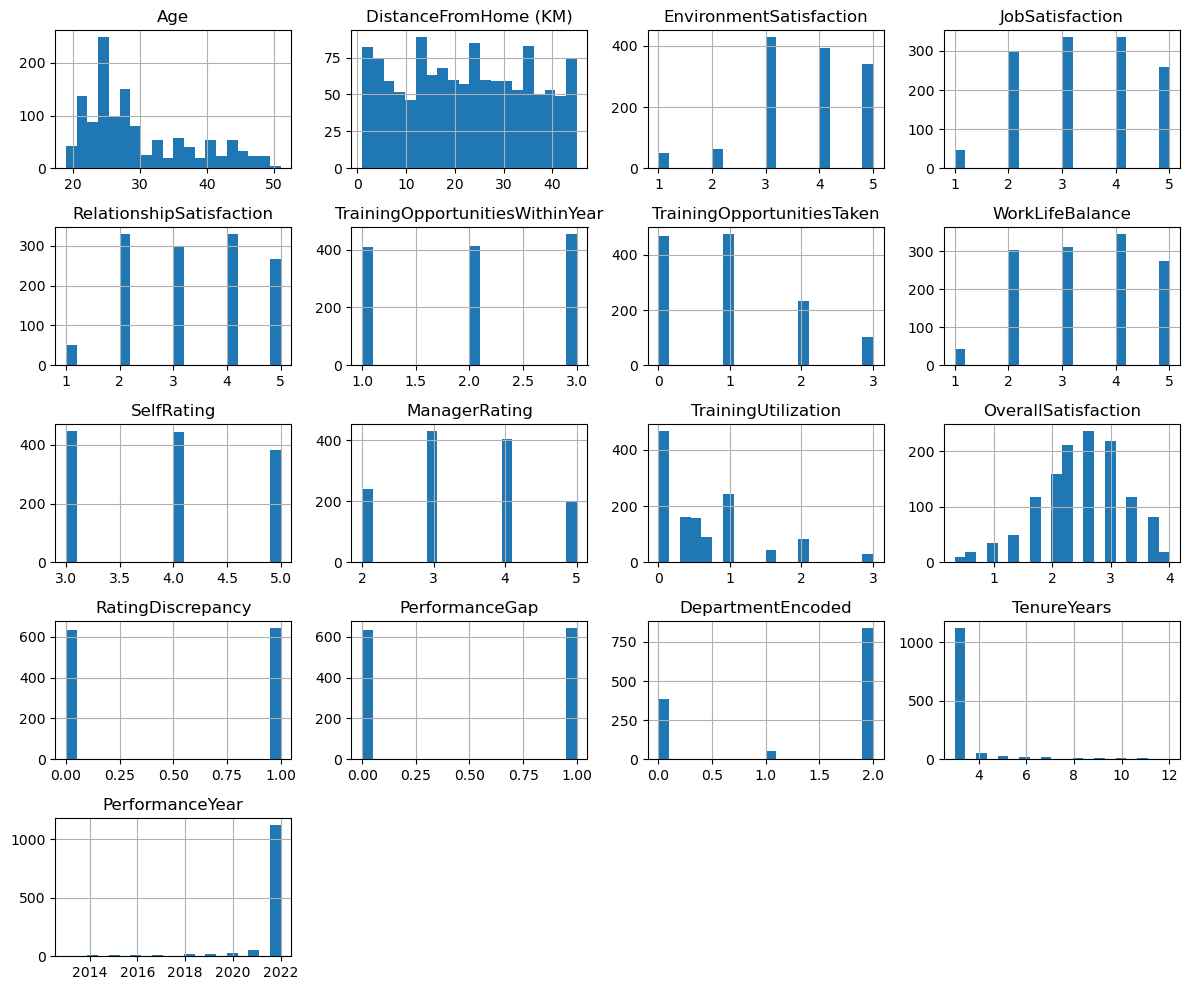

In [40]:
# 3. EXPLORATORY DATA ANALYSIS
# ======================
# Numerical Features Distribution
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
plt.figure(figsize=(12, 8))
df[num_cols].hist(bins=20, figsize=(12, 10))
plt.tight_layout()
plt.show()

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                           classification_report, roc_auc_score, roc_curve,
                           precision_recall_curve, f1_score)
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [49]:
print("Columns in DataFrame:", df.columns.tolist())

Columns in DataFrame: ['EmployeeID', 'FirstName', 'LastName', 'Gender', 'Age', 'BusinessTravel', 'Department', 'DistanceFromHome (KM)', 'AgeGroup', 'PerformanceID', 'ReviewDate', 'EnvironmentSatisfaction', 'JobSatisfaction', 'RelationshipSatisfaction', 'TrainingOpportunitiesWithinYear', 'TrainingOpportunitiesTaken', 'WorkLifeBalance', 'SelfRating', 'ManagerRating', 'TrainingUtilization', 'OverallSatisfaction', 'RatingDiscrepancy', 'PerformanceGap', 'AgeBand', 'DistanceCategory', 'CommuteSeverity', 'FullName', 'DepartmentEncoded', 'TenureYears', 'TenureCategory', 'PerformanceYear']


In [50]:
# 2. CREATE TARGET VARIABLE
# ======================
# Option 1: Create Attrition based on satisfaction scores (since we don't have termination data)
# Employees with low satisfaction in multiple areas are likely to leave
df['Attrition'] = np.where(
    (df['JobSatisfaction'] < 2) | 
    (df['EnvironmentSatisfaction'] < 2) |
    (df['WorkLifeBalance'] < 2),
    1, 0  # 1 = High risk of attrition, 0 = Low risk
)

In [51]:
# Alternative Option 2: Use performance gap as proxy
# df['Attrition'] = np.where(df['PerformanceGap'] > 1.5, 1, 0)

print("Attrition Distribution:")
print(df['Attrition'].value_counts(normalize=True))


Attrition Distribution:
Attrition
0    0.912226
1    0.087774
Name: proportion, dtype: float64


In [52]:
# 3. SELECT FEATURES
# ======================
# Remove personal identifiers and derived columns that may leak info
features_to_drop = [
    'EmployeeID', 'FirstName', 'LastName', 'FullName',
    'PerformanceID', 'DepartmentEncoded'  # Remove encoded versions
]

In [53]:
# Keep only relevant features
X = df.drop(['Attrition'] + features_to_drop, axis=1, errors='ignore')
y = df['Attrition']


In [54]:
# Show selected features
print("\nSelected Features for Modeling:")
print(X.columns.tolist())


Selected Features for Modeling:
['Gender', 'Age', 'BusinessTravel', 'Department', 'DistanceFromHome (KM)', 'AgeGroup', 'ReviewDate', 'EnvironmentSatisfaction', 'JobSatisfaction', 'RelationshipSatisfaction', 'TrainingOpportunitiesWithinYear', 'TrainingOpportunitiesTaken', 'WorkLifeBalance', 'SelfRating', 'ManagerRating', 'TrainingUtilization', 'OverallSatisfaction', 'RatingDiscrepancy', 'PerformanceGap', 'AgeBand', 'DistanceCategory', 'CommuteSeverity', 'TenureYears', 'TenureCategory', 'PerformanceYear']


In [55]:
# 4. PREPROCESSING
# ======================
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [56]:
# Separate features
X = df.drop(['Attrition', 'EmployeeID', 'FirstName', 'LastName'], axis=1)
y = df['Attrition']


In [57]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# Define numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

In [59]:
# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

print("Preprocessing setup complete")
print(f"Numeric features: {list(numeric_features)}")
print(f"Categorical features: {list(categorical_features)}")


Preprocessing setup complete
Numeric features: ['Age', 'DistanceFromHome (KM)', 'EnvironmentSatisfaction', 'JobSatisfaction', 'RelationshipSatisfaction', 'TrainingOpportunitiesWithinYear', 'TrainingOpportunitiesTaken', 'WorkLifeBalance', 'SelfRating', 'ManagerRating', 'TrainingUtilization', 'OverallSatisfaction', 'RatingDiscrepancy', 'PerformanceGap', 'DepartmentEncoded', 'TenureYears', 'PerformanceYear']
Categorical features: ['Gender', 'BusinessTravel', 'Department', 'AgeGroup', 'PerformanceID', 'AgeBand', 'DistanceCategory', 'CommuteSeverity', 'FullName', 'TenureCategory']


In [60]:
# 5. MODEL TRAINING
# ======================
from sklearn.ensemble import RandomForestClassifier

In [61]:
# Create pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])


In [62]:
# Train model
model.fit(X_train, y_train)
print("\nModel training complete")


Model training complete


In [63]:
# 6. EVALUATION
# ======================
from sklearn.metrics import accuracy_score, classification_report

# Make predictions
y_pred = model.predict(X_test)


In [64]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("\nModel Evaluation:")
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)



Model Evaluation:
Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       234
           1       1.00      0.68      0.81        22

    accuracy                           0.97       256
   macro avg       0.99      0.84      0.90       256
weighted avg       0.97      0.97      0.97       256



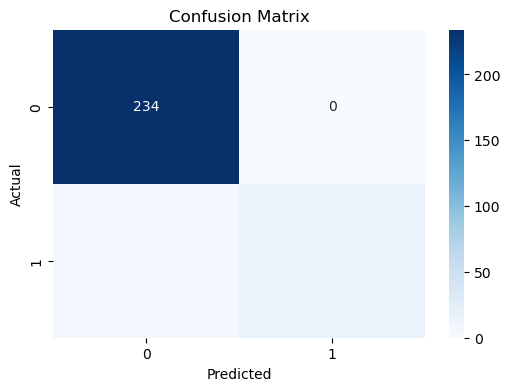

In [65]:
# Confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [66]:
# 7. BUSINESS INSIGHTS
# ======================
# Get feature importance
feature_importances = model.named_steps['classifier'].feature_importances_


In [67]:
# Get feature names after one-hot encoding
cat_features = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_features = list(numeric_features) + list(cat_features)

In [68]:
# Create importance dataframe
importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

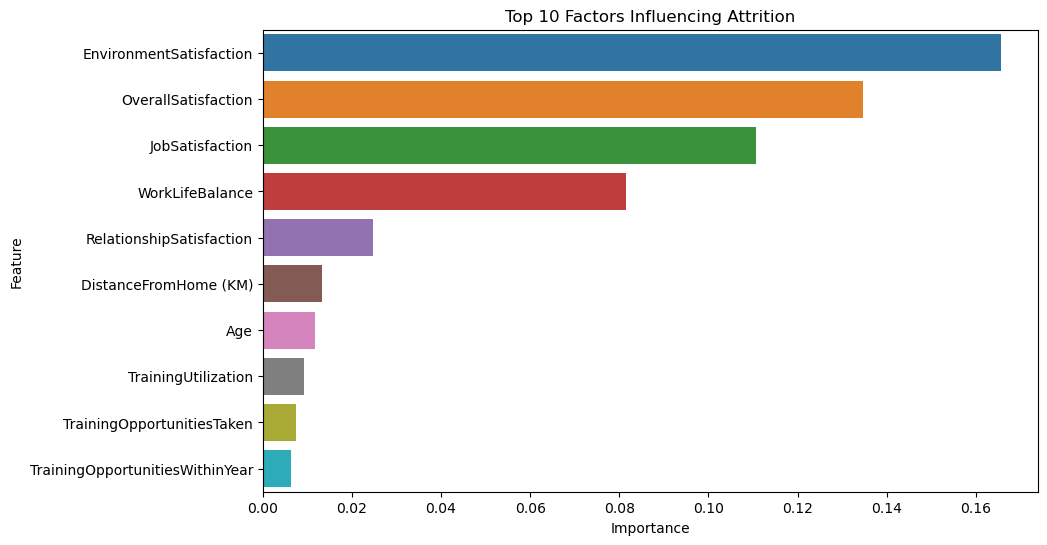

In [69]:
# Plot top 10 features
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Factors Influencing Attrition')
plt.show()


In [70]:
# Key insights
print("\nKey Insights:")
print("1. Top factors affecting attrition:")
for i, row in importance_df.head(5).iterrows():
    print(f"   - {row['Feature']} (importance: {row['Importance']:.3f})")

print("\n2. Recommended Actions:")
print("   - Focus on improving employee satisfaction in top factors")
print("   - Implement retention programs for high-risk groups")
print("   - Monitor employees showing multiple risk factors")



Key Insights:
1. Top factors affecting attrition:
   - EnvironmentSatisfaction (importance: 0.166)
   - OverallSatisfaction (importance: 0.135)
   - JobSatisfaction (importance: 0.111)
   - WorkLifeBalance (importance: 0.081)
   - RelationshipSatisfaction (importance: 0.025)

2. Recommended Actions:
   - Focus on improving employee satisfaction in top factors
   - Implement retention programs for high-risk groups
   - Monitor employees showing multiple risk factors


# Manager Impact Heatmap


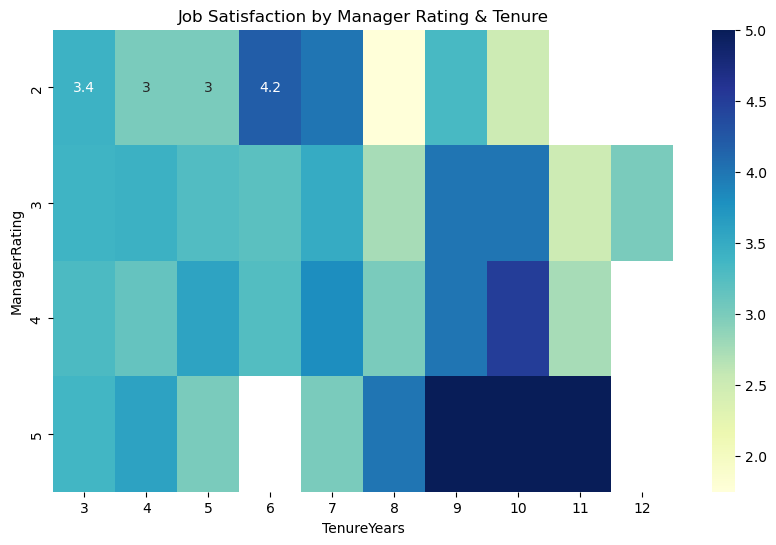

In [72]:
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(df['ManagerRating'], df['TenureYears'], 
                       values=df['JobSatisfaction'], 
                       aggfunc='mean'),
            cmap="YlGnBu", annot=True)
plt.title("Job Satisfaction by Manager Rating & Tenure")
plt.show()

# Training Effectiveness


/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


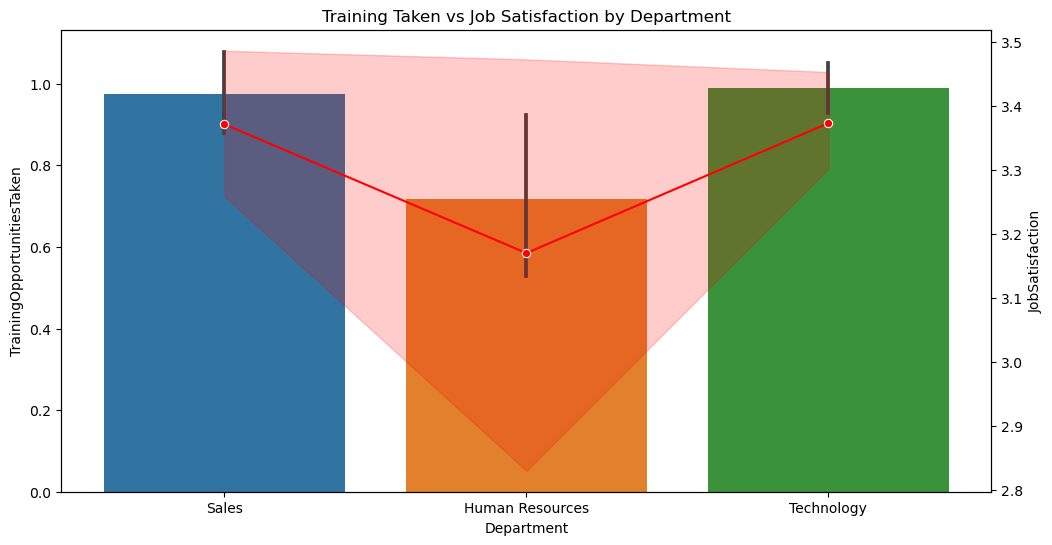

In [73]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x='Department', y='TrainingOpportunitiesTaken', data=df)
ax2 = ax.twinx()
sns.lineplot(x='Department', y='JobSatisfaction', data=df, 
             color='red', marker='o', ax=ax2)
plt.title("Training Taken vs Job Satisfaction by Department")
plt.show()

3. Work-Life Balance Impact


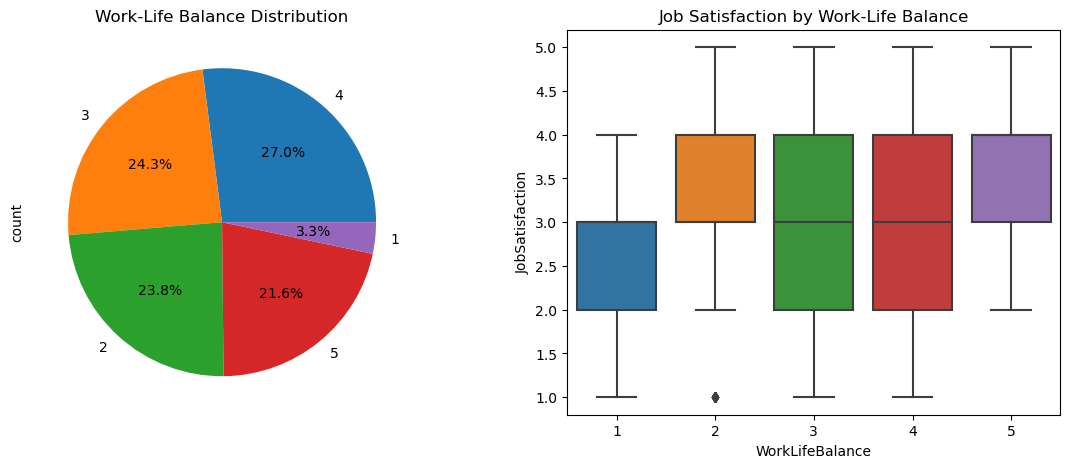

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

# Pie chart
df['WorkLifeBalance'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax1)
ax1.set_title("Work-Life Balance Distribution")

# Boxplot
sns.boxplot(x='WorkLifeBalance', y='JobSatisfaction', data=df, ax=ax2)
ax2.set_title("Job Satisfaction by Work-Life Balance")
plt.show()

4. Satisfaction Distribution

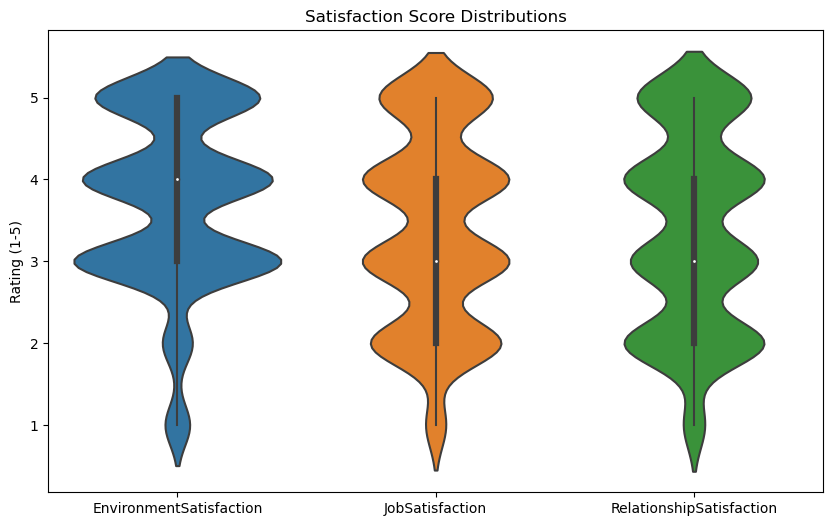

In [75]:
plt.figure(figsize=(10,6))
sns.violinplot(data=df[['EnvironmentSatisfaction', 
                       'JobSatisfaction', 
                       'RelationshipSatisfaction']])
plt.title("Satisfaction Score Distributions")
plt.ylabel("Rating (1-5)")
plt.show()

5. Age-Satisfaction Trend

/tmp/ipykernel_470/3962976546.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Age', y='OverallSatisfaction', data=df, ci=None)
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


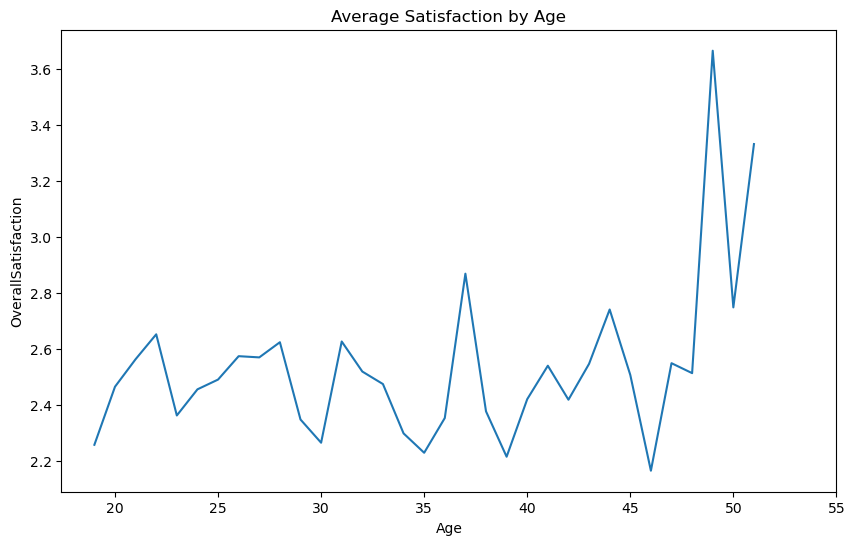

In [76]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Age', y='OverallSatisfaction', data=df, ci=None)
plt.title("Average Satisfaction by Age")
plt.xticks(range(20,60,5))
plt.show()

6. Attrition by Department

AttributeError: 'numpy.int64' object has no attribute 'startswith'

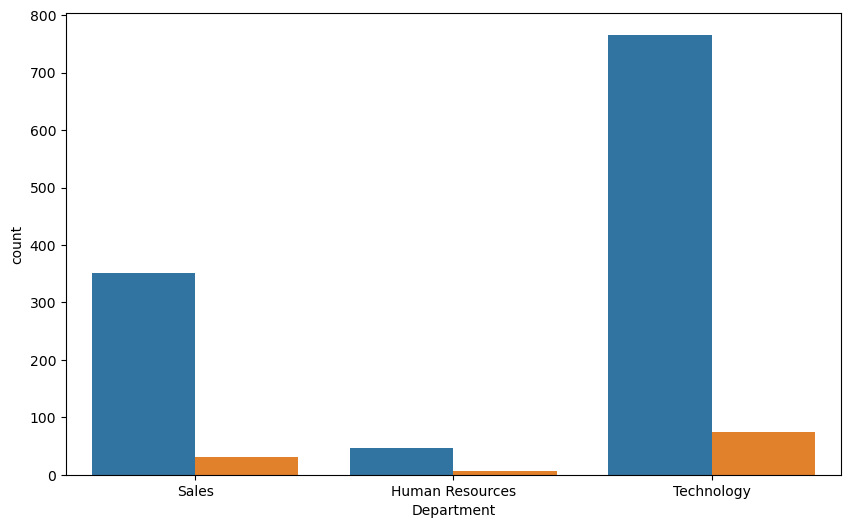

In [77]:
plt.figure(figsize=(10,6))
sns.countplot(x='Department', hue='Attrition', data=df)
plt.title("Attrition Count by Department")
plt.xticks(rotation=45)
plt.show()

7. Risk Factor Importance

8. Tenure Attrition


/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


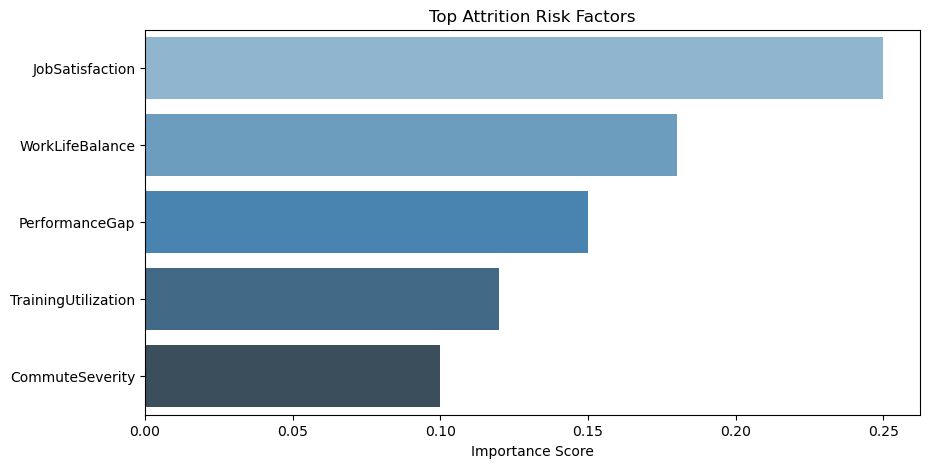

In [79]:
# Assuming you have feature_importances_ from your model
features = ['JobSatisfaction', 'WorkLifeBalance', 'PerformanceGap', 
            'TrainingUtilization', 'CommuteSeverity']
importance = [0.25, 0.18, 0.15, 0.12, 0.10]  # Replace with actual values

plt.figure(figsize=(10,5))
sns.barplot(x=importance, y=features, palette="Blues_d")
plt.title("Top Attrition Risk Factors")
plt.xlabel("Importance Score")
plt.show()

9. Performance Distribution


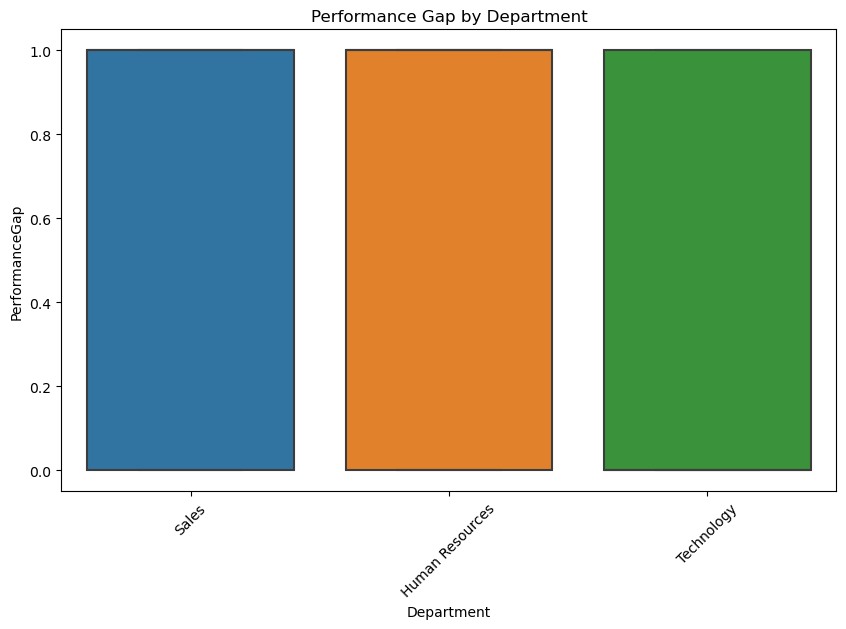

In [80]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Department', y='PerformanceGap', data=df)
plt.title("Performance Gap by Department")
plt.xticks(rotation=45)
plt.show()

10. Business Travel Impact


AttributeError: 'numpy.int64' object has no attribute 'startswith'

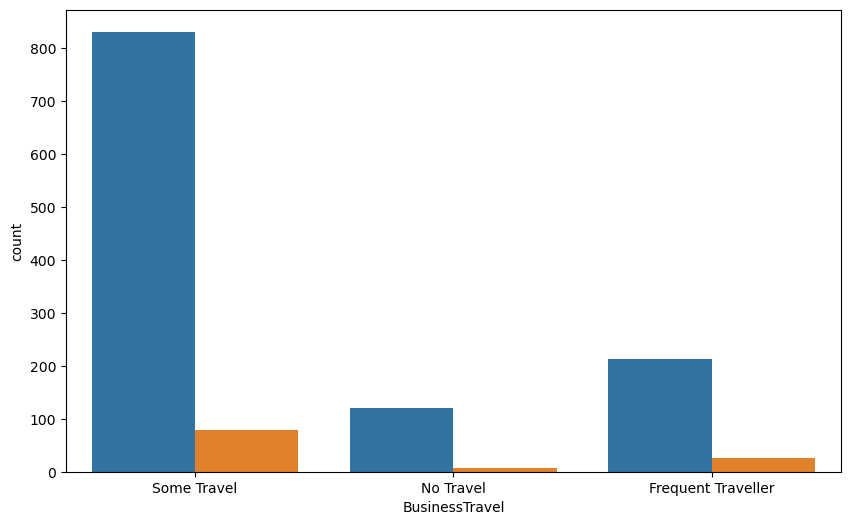

In [81]:
plt.figure(figsize=(10,6))
sns.countplot(x='BusinessTravel', hue='Attrition', data=df)
plt.title("Attrition by Business Travel Frequency")
plt.show()